In [1]:
!pip install arviz pymc numpyro jax

In [2]:
import arviz as az
import pymc as pmc
import numpyro
from numpyro import distributions as dist

import numpy as np
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt

import logging
logging.basicConfig()
logger = logging.getLogger('pymc')
logger.setLevel(logging.CRITICAL)


In [3]:
def ar1_simulate(rho, sigma, y0, T):

    # Allocate space and draw epsilons
    y = np.empty(T)
    eps = np.random.normal(0.,sigma,T)

    # Initial condition and step forward
    y[0] = y0
    for t in range(1, T):
        y[t] = rho*y[t-1] + eps[t]

    return y

sigma =  1.
rho = 0.5
T = 50

np.random.seed(145353452)
y = ar1_simulate(rho, sigma, 10, T)

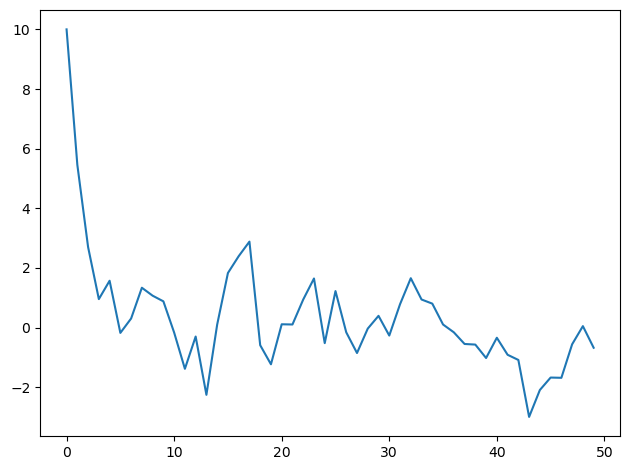

In [4]:
plt.plot(y)
plt.tight_layout()

In [5]:
AR1_model = pmc.Model()

with AR1_model:

    # Start with priors
    rho = pmc.Uniform('rho', lower=-1., upper=1.) # Assume stable rho
    sigma = pmc.HalfNormal('sigma', sigma = np.sqrt(10))

    # Expected value of y at the next period (rho * y)
    yhat = rho * y[:-1]

    # Likelihood of the actual realization
    y_like = pmc.Normal('y_obs', mu=yhat, sigma=sigma, observed=y[1:])

In [6]:
with AR1_model:
    trace = pmc.sample(50000, tune=10000, return_inferencedata=True)

/Users/humphreyyang/anaconda3/envs/quantecon_test/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


/Users/humphreyyang/anaconda3/envs/quantecon_test/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


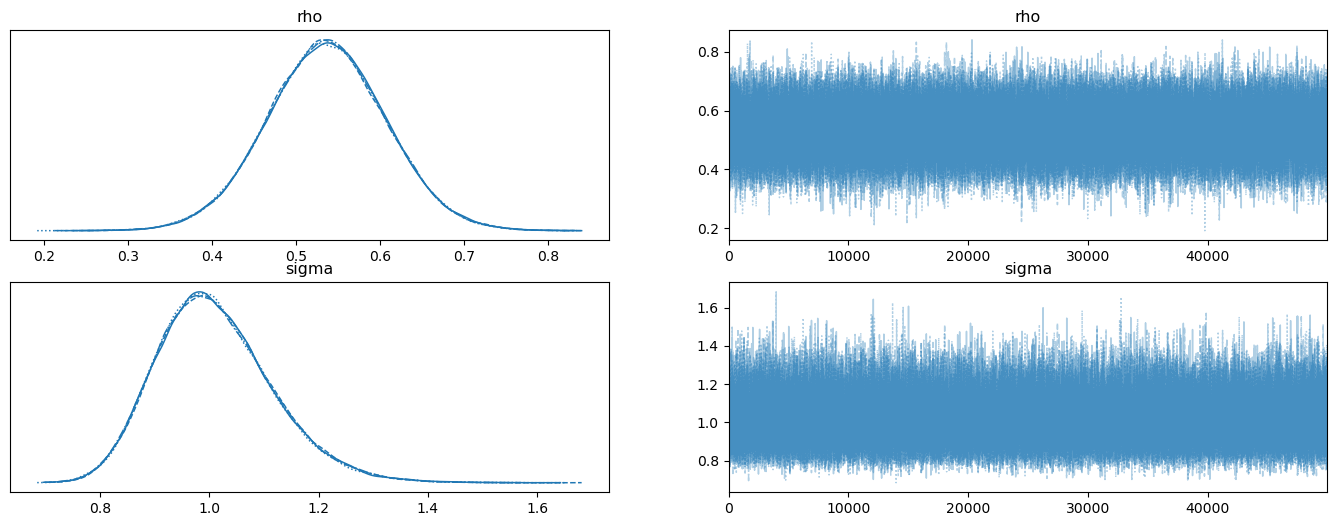

In [7]:
with AR1_model:
    az.plot_trace(trace, figsize=(17,6))

In [8]:
with AR1_model:
    summary = az.summary(trace, round_to=4)

summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho,0.5361,0.0709,0.4003,0.6679,0.0002,0.0001,177625.6411,124240.6983,1.0
sigma,1.0103,0.1064,0.8175,1.2105,0.0003,0.0002,180151.5908,140894.6331,1.0


In [9]:
AR1_model_y0 = pmc.Model()

with AR1_model_y0:

    # Start with priors
    rho = pmc.Uniform('rho', lower=-1., upper=1.) # Assume stable rho
    sigma = pmc.HalfNormal('sigma', sigma=np.sqrt(10))

    # Standard deviation of ergodic y
    y_sd = sigma / np.sqrt(1 - rho**2)

    # yhat
    yhat = rho * y[:-1]
    y_data = pmc.Normal('y_obs', mu=yhat, sigma=sigma, observed=y[1:])
    y0_data = pmc.Normal('y0_obs', mu=0., sigma=y_sd, observed=y[0])

In [10]:
with AR1_model_y0:
    trace_y0 = pmc.sample(50000, tune=10000, return_inferencedata=True)

# Grey vertical lines are the cases of divergence

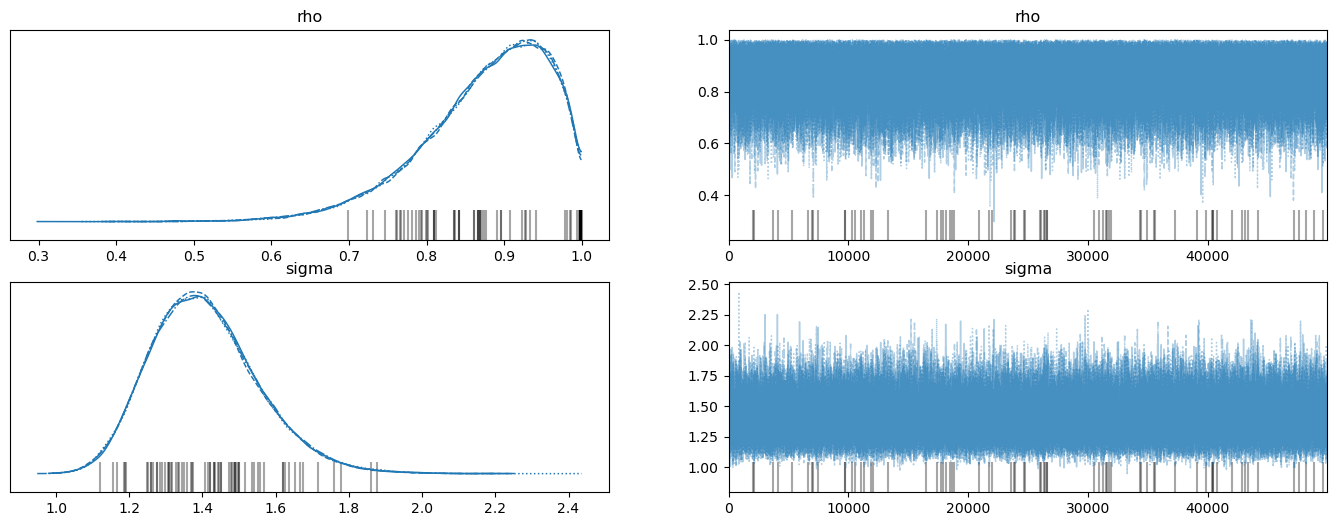

In [11]:
with AR1_model_y0:
    az.plot_trace(trace_y0, figsize=(17,6))

In [12]:
with AR1_model:
    summary_y0 = az.summary(trace_y0, round_to=4)

summary_y0

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho,0.8760,0.0816,0.7315,0.9995,0.0002,0.0002,107739.5117,78568.8757,1.0
sigma,1.4046,0.1473,1.1410,1.6831,0.0004,0.0003,127554.9004,104906.9737,1.0


In [13]:

def plot_posterior(sample):
    """
    Plot trace and histogram
    """
    # To np array
    rhos = sample['rho']
    sigmas = sample['sigma']
    rhos, sigmas, = np.array(rhos), np.array(sigmas)

    fig, axs = plt.subplots(2, 2, figsize=(17, 6))
    # Plot trace
    axs[0, 0].plot(rhos)   # rho
    axs[1, 0].plot(sigmas) # sigma

    # Plot posterior
    axs[0, 1].hist(rhos, bins=50, density=True, alpha=0.7)
    axs[0, 1].set_xlim([0, 1])
    axs[1, 1].hist(sigmas, bins=50, density=True, alpha=0.7)

    axs[0, 0].set_title("rho")
    axs[0, 1].set_title("rho")
    axs[1, 0].set_title("sigma")
    axs[1, 1].set_title("sigma")
    plt.show()

In [14]:
def AR1_model(data):
    # set prior
    rho = numpyro.sample('rho', dist.Uniform(low=-1., high=1.))
    sigma = numpyro.sample('sigma', dist.HalfNormal(scale=np.sqrt(10)))

    # Expected value of y at the next period (rho * y)
    yhat = rho * data[:-1]

    # Likelihood of the actual realization.
    y_data = numpyro.sample('y_obs', dist.Normal(loc=yhat, scale=sigma), obs=data[1:])


In [15]:
# Make jnp array
y = jnp.array(y)

# Set NUTS kernal
NUTS_kernel = numpyro.infer.NUTS(AR1_model)

# Run MCMC
mcmc = numpyro.infer.MCMC(NUTS_kernel, num_samples=50000, num_warmup=10000, progress_bar=False)
mcmc.run(rng_key=random.PRNGKey(1), data=y)

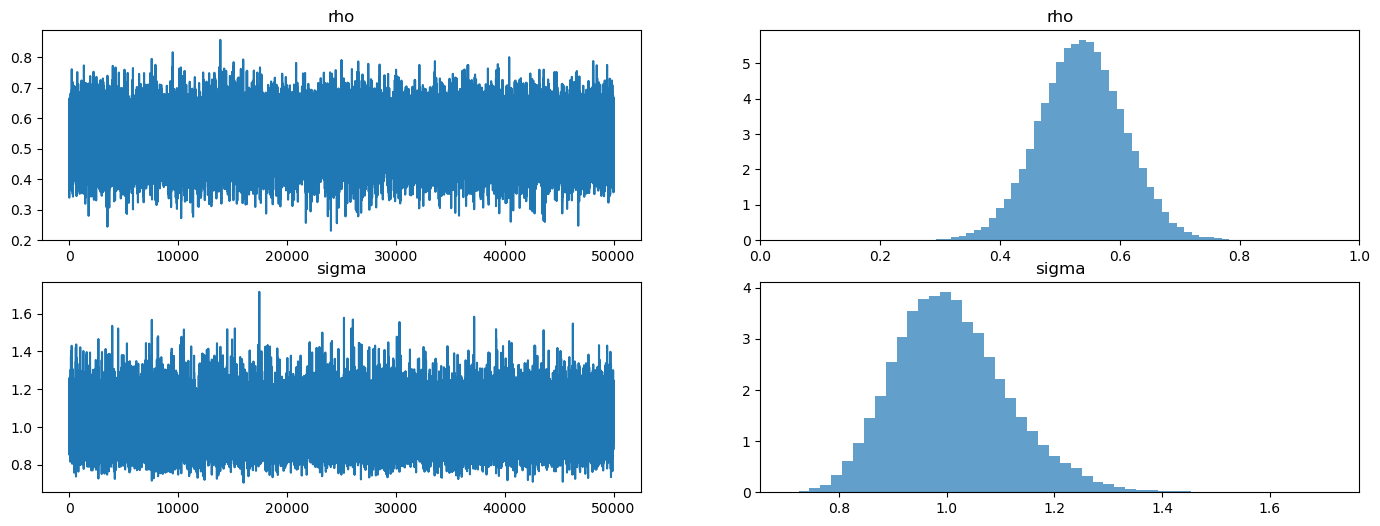

In [16]:
plot_posterior(mcmc.get_samples())

In [17]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       rho      0.54      0.07      0.54      0.42      0.65  31483.32      1.00
     sigma      1.01      0.11      1.00      0.84      1.18  32669.54      1.00

Number of divergences: 0


In [18]:
def AR1_model_y0(data):
    # Set prior
    rho = numpyro.sample('rho', dist.Uniform(low=-1., high=1.))
    sigma = numpyro.sample('sigma', dist.HalfNormal(scale=np.sqrt(10)))

    # Standard deviation of ergodic y
    y_sd = sigma / jnp.sqrt(1 - rho**2)

    # Expected value of y at the next period (rho * y)
    yhat = rho * data[:-1]

    # Likelihood of the actual realization.
    y_data = numpyro.sample('y_obs', dist.Normal(loc=yhat, scale=sigma), obs=data[1:])
    y0_data = numpyro.sample('y0_obs', dist.Normal(loc=0., scale=y_sd), obs=data[0])

In [19]:
# Make jnp array
y = jnp.array(y)

# Set NUTS kernal
NUTS_kernel = numpyro.infer.NUTS(AR1_model_y0)

# Run MCMC
mcmc2 = numpyro.infer.MCMC(NUTS_kernel, num_samples=50000, num_warmup=10000, progress_bar=False)
mcmc2.run(rng_key=random.PRNGKey(1), data=y)

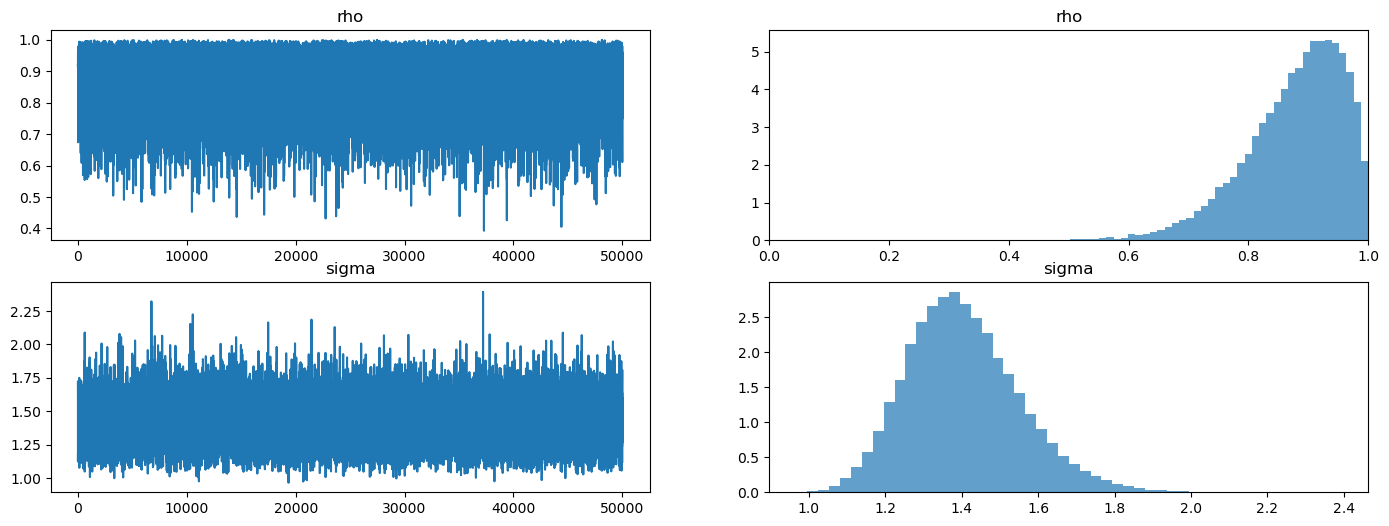

In [20]:
plot_posterior(mcmc2.get_samples())

In [21]:
mcmc2.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       rho      0.88      0.08      0.89      0.76      1.00  27638.50      1.00
     sigma      1.40      0.15      1.39      1.17      1.64  24358.14      1.00

Number of divergences: 0
